# STOR 320 Introduction to Data Science

## Week 10: Cross validation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Helper Functions

In [2]:
def OSR2(y_train, y_test, y_pred):
    
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [3]:
def MAE(y_test, y_pred):
    
    return (np.mean(abs(y_test - y_pred)))

In [4]:
def RMSE(y_test, y_pred):
    
    return np.sqrt(np.mean((y_test - y_pred)**2))

In [5]:
def print_metrics(model, X_train, y_train, X_test, y_test, flag_log_sale_price=False):

    if (flag_log_sale_price == True):
        
        y_pred_train = pd.Series(model.predict(X_train)).reset_index(drop=True)
        y_pred_test = pd.Series(model.predict(X_test)).reset_index(drop=True)
        y_train = y_train.copy().reset_index(drop=True)
        y_test = y_test.copy().reset_index(drop=True)
        
        print("\nMetrics for Log(Sale Price):\n")
        
    elif (flag_log_sale_price == False):
        
        y_pred_train = pd.Series(model.predict(X_train)).apply(np.exp).reset_index(drop=True)
        y_pred_test = pd.Series(model.predict(X_test)).apply(np.exp).reset_index(drop=True)
        y_train = y_train.copy().apply(np.exp).reset_index(drop=True)
        y_test = y_test.copy().apply(np.exp).reset_index(drop=True)
        
        print("\nMetrics for Sale Price:\n")

    print('Training R2', OSR2(y_train, y_train, y_pred_train))
    print('Training MAE', MAE(y_train, y_pred_train))
    print('Training RMSE', RMSE(y_train, y_pred_train))

    print('Out-of-sample R2', OSR2(y_train, y_test, y_pred_test))
    print('Out-of-sample MAE', MAE(y_test, y_pred_test))
    print('Out-of-sample RMSE', RMSE(y_test, y_pred_test))
    
    return None

In [6]:
ames = pd.read_csv('cleaned_Ames.csv')
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2765 entries, 0 to 2764
Columns: 105 entries, Unnamed: 0 to YearsSince1950GarageBuilt
dtypes: float64(21), int64(45), object(39)
memory usage: 2.2+ MB


In [7]:
ames = pd.read_feather('cleaned_ames.feather')
ames

,LogSalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PreCast,Stone,Stucco,VinylSd,WdSdng,WdShing,WdShng,YearsSince1950Built,YearsSince1950Remod,YearsSince1950GarageBuilt
0,12.278393,20,RL,141.0,31770.0,Pave,NoAccess,IR1,Lvl,AllPub,...,0,0,0,0,0,0,0,10,10,10.0
1,11.561716,20,RH,80.0,11622.0,Pave,NoAccess,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,11,11,11.0
2,12.055250,20,RL,81.0,14267.0,Pave,NoAccess,IR1,Lvl,AllPub,...,0,0,0,0,1,0,0,8,8,8.0
3,12.404924,20,RL,93.0,11160.0,Pave,NoAccess,Reg,Lvl,AllPub,...,0,0,0,0,0,0,0,18,18,18.0
4,12.154253,60,RL,74.0,13830.0,Pave,NoAccess,IR1,Lvl,AllPub,...,0,0,0,1,0,0,0,47,48,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,11.782953,20,RL,160.0,20000.0,Pave,NoAccess,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,10,46,10.0
2925,11.867097,80,RL,37.0,7937.0,Pave,NoAccess,IR1,Lvl,AllPub,...,0,0,0,0,0,0,0,34,34,34.0
2926,11.782953,20,RL,0.0,8885.0,Pave,NoAccess,IR1,Low,AllPub,...,0,0,0,0,0,0,0,33,33,33.0
2928,12.043554,20,RL,77.0,10010.0,Pave,NoAccess,Reg,Lvl,AllPub,...,0,0,0,0,0,0,0,24,25,25.0


In [8]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2765 entries, 0 to 2929
Columns: 105 entries, LogSalePrice to YearsSince1950GarageBuilt
dtypes: category(53), float64(21), int64(31)
memory usage: 1.3 MB


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
ames_train = ames.loc[ames['YrSold'].isin([2006, 2007, 2008])]
ames_test = ames.loc[ames['YrSold'].isin([2009, 2010])]

ames = ames.drop(columns = ['YrSold'])
ames_train = ames_train.drop(columns = ['YrSold'])
ames_test = ames_test.drop(columns = ['YrSold'])

y_train = ames_train['LogSalePrice']
y_test = ames_test['LogSalePrice']

print(ames.shape, ames_train.shape, ames_test.shape)

(2765, 104) (1828, 104) (937, 104)


### Simple Linear model with higher-order Variables


In [11]:
def create_polynomial_features(df, n_degree):

    new_df = None
    
    for i in range(2, n_degree+1):
        
        tmp = df.pow(i)
        
        affix = '_p'+str(i)
        tmp.columns = list(map(lambda x: x + affix, df.columns))
        
        if new_df is not None:
            new_df = pd.concat([new_df, tmp], axis=1)
        else:
            new_df = tmp
    
    return new_df

<span style='color:blue'>
    
NOTE: An important consideration when creating higher-order variables is that the resulting features will tend to have some degree of linear dependence amongst themselves. This is normal as several new features are based on their zero-th power peer. Such correlation can also yield a high degree of multicollinearity in the regression models. The `sklearn` implementations that we will be using do not automatically account for this phenomenon, therefore we must be careful in selection the `n_degree`, and analyzing the model fit. 

</span>

In [12]:
# We only choose a select list of variables to do polynomial transformation.
poly_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
             'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
             'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'MiscVal', 'YearsSince1950Built',
             'YearsSince1950Remod', 'YearsSince1950GarageBuilt']

In [13]:
n_degree = 2

train_poly_temp = create_polynomial_features(ames_train[poly_cols], n_degree)
test_poly_temp = create_polynomial_features(ames_test[poly_cols], n_degree)

ames_train_poly = pd.concat([ames_train, train_poly_temp], axis=1)
ames_test_poly = pd.concat([ames_test, test_poly_temp], axis=1)

print(ames_train.shape, ames_test.shape)
print(train_poly_temp.shape, test_poly_temp.shape)
print(ames_train_poly.shape, ames_test_poly.shape)

(1828, 104) (937, 104)
(1828, 21) (937, 21)
(1828, 125) (937, 125)


In [14]:
print(ames_train_poly.shape)
all_columns = "+".join(ames_train_poly.columns.difference(["LogSalePrice"]))
my_formula = "LogSalePrice~" + all_columns +'-1'
print(my_formula)

mod_naive_poly = smf.ols(my_formula, data=ames_train_poly)
nlr_poly = mod_naive_poly.fit()

print(nlr_poly.summary())

(1828, 125)
LogSalePrice~Alley+Artery+AsbShng+AsphShn+BedroomAbvGr+BldgType+BrkCmn+BrkComm+BrkFace+BsmtCond+BsmtExposure+BsmtFinSF1+BsmtFinSF1_p2+BsmtFinSF2+BsmtFinSF2_p2+BsmtFinType1+BsmtFinType2+BsmtFullBath+BsmtHalfBath+BsmtQual+BsmtUnfSF+BsmtUnfSF_p2+CBlock+CemntBd+CentralAir+CmentBd+Electrical+EnclosedPorch+EnclosedPorch_p2+ExterCond+ExterQual+Feedr+Fence+FireplaceQu+Fireplaces+Foundation+FullBath+Functional+GarageArea+GarageArea_p2+GarageCars+GarageCond+GarageFinish+GarageQual+GarageType+GrLivArea+GrLivArea_p2+HalfBath+HdBoard+Heating+HeatingQC+HouseStyle+ImStucc+KitchenAbvGr+KitchenQual+LandContour+LandSlope+LotArea+LotArea_p2+LotConfig+LotFrontage+LotFrontage_p2+LotShape+LowQualFinSF+LowQualFinSF_p2+MSSubClass+MSZoning+MasVnrArea+MasVnrArea_p2+MasVnrType+MetalSd+MiscFeature+MiscVal+MiscVal_p2+MoSold+Neighborhood+Norm+OpenPorchSF+OpenPorchSF_p2+Other+OverallCond+OverallQual+PavedDrive+Plywood+PoolArea+PoolQC+PosA+PosN+PreCast+RRAe+RRAn+RRNe+RRNn+RoofMatl+RoofStyle+SaleCondition+

In [15]:
print_metrics(nlr_poly, ames_train_poly, y_train, ames_test_poly, y_test, flag_log_sale_price = True)
print_metrics(nlr_poly, ames_train_poly, y_train, ames_test_poly, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.9624105774575185
Training MAE 0.05428713187831344
Training RMSE 0.07504602800253764
Out-of-sample R2 0.8389618470389943
Out-of-sample MAE 0.08377525015006256
Out-of-sample RMSE 0.15893909023513655

Metrics for Sale Price:

Training R2 0.9640398351503799
Training MAE 9959.9415261308
Training RMSE 14814.210314147367
Out-of-sample R2 0.42824990275266905
Out-of-sample MAE 15888.470959526549
Out-of-sample RMSE 59264.318499926754


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

## Tuning parameters for LASSO

In [17]:
X_train_poly = ames_train_poly.drop(columns='LogSalePrice')
X_test_poly = ames_test_poly.drop(columns='LogSalePrice')

X_train_poly_wide = pd.get_dummies(X_train_poly)
X_test_poly_wide = pd.get_dummies(X_test_poly)

In [18]:
X_train_lasso = X_train_poly_wide
X_test_lasso = X_test_poly_wide

print(X_train_lasso.shape, X_test_lasso.shape)

(1828, 397) (937, 397)


In [19]:
alpha = 0.1
lasso = Lasso(alpha=alpha, random_state=88)
lasso.fit(X_train_lasso, y_train)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = True)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.8434328276296639
Training MAE 0.10512146274745086
Training RMSE 0.15315995785273875
Out-of-sample R2 0.8272606660089641
Out-of-sample MAE 0.11098188208314018
Out-of-sample RMSE 0.1646121748477917

Metrics for Sale Price:

Training R2 0.8771753803277366
Training MAE 18703.62412014218
Training RMSE 27378.546173438564
Out-of-sample R2 0.8763647003108185
Out-of-sample MAE 19243.304403735783
Out-of-sample RMSE 27558.870499831355


In [20]:
alpha = 1e-2
lasso = Lasso(alpha=alpha, random_state=88)
lasso.fit(X_train_lasso, y_train)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = True)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.8499429858739374
Training MAE 0.10300561266815048
Training RMSE 0.1499419084810546
Out-of-sample R2 0.8220062230158947
Out-of-sample MAE 0.11032085223765256
Out-of-sample RMSE 0.16709703425025807

Metrics for Sale Price:

Training R2 0.8817688305547458
Training MAE 18354.387859038405
Training RMSE 26861.71033834519
Out-of-sample R2 0.8640371155817245
Out-of-sample MAE 19243.388183114424
Out-of-sample RMSE 28900.16723185019


In [21]:
alpha = 1e-3
lasso = Lasso(alpha=alpha, random_state=88)
lasso.fit(X_train_lasso, y_train)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = True)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.930121322344742
Training MAE 0.0693863840072313
Training RMSE 0.10232157655865007
Out-of-sample R2 0.8874024847675652
Out-of-sample MAE 0.08314147804623102
Out-of-sample RMSE 0.13290176107494575

Metrics for Sale Price:

Training R2 0.9414769024277362
Training MAE 12459.409164012955
Training RMSE 18898.673470545342
Out-of-sample R2 0.9194885352942028
Out-of-sample MAE 14287.152645232196
Out-of-sample RMSE 22239.193567377857


In [22]:
alpha = 1e-4
lasso = Lasso(alpha=alpha, random_state=88)
lasso.fit(X_train_lasso, y_train)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = True)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.9591387227010627
Training MAE 0.05679795053144252
Training RMSE 0.07824396555230513
Out-of-sample R2 0.8989936623088266
Out-of-sample MAE 0.07800037399372267
Out-of-sample RMSE 0.12587533655731084

Metrics for Sale Price:

Training R2 0.9611684976129613
Training MAE 10369.737135417017
Training RMSE 15394.293622412848
Out-of-sample R2 0.9310061238902255
Out-of-sample MAE 13389.285161194184
Out-of-sample RMSE 20587.112764707137


In [23]:
alpha = 1e-5
lasso = Lasso(alpha=alpha, random_state=88)
lasso.fit(X_train_lasso, y_train)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = True)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.9622832237041625
Training MAE 0.05457420034317798
Training RMSE 0.0751730492656569
Out-of-sample R2 0.8881083316233747
Out-of-sample MAE 0.07994225740632856
Out-of-sample RMSE 0.13248454152958558

Metrics for Sale Price:

Training R2 0.9638757207480595
Training MAE 10010.81646880421
Training RMSE 14847.976256226326
Out-of-sample R2 0.9272909790616876
Out-of-sample MAE 13681.307280622397
Out-of-sample RMSE 21134.127319826755


In [24]:
alpha = 1e-6
lasso = Lasso(alpha=alpha, random_state=88)
lasso.fit(X_train_lasso, y_train)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = True)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.9624088075098128
Training MAE 0.05432119722133529
Training RMSE 0.07504779480251142
Out-of-sample R2 0.887174332291282
Out-of-sample MAE 0.08045121076601408
Out-of-sample RMSE 0.13303634007223722

Metrics for Sale Price:

Training R2 0.9640275202363419
Training MAE 9965.285133817228
Training RMSE 14816.7467334153
Out-of-sample R2 0.9267533208150691
Out-of-sample MAE 13751.7824584604
Out-of-sample RMSE 21212.12320497363


In [25]:
MAE_list = []
candidate_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

for alpha in candidate_values:
    lasso = Lasso(alpha=alpha, random_state=88)
    lasso.fit(X_train_lasso, y_train)
    y_pred_test = pd.Series(lasso.predict(X_test_lasso)).apply(np.exp).reset_index(drop=True)
    y_train_exp = y_train.copy().apply(np.exp).reset_index(drop=True)
    y_test_exp = y_test.copy().apply(np.exp).reset_index(drop=True)
    MAE_list.append(MAE(y_test_exp, y_pred_test))

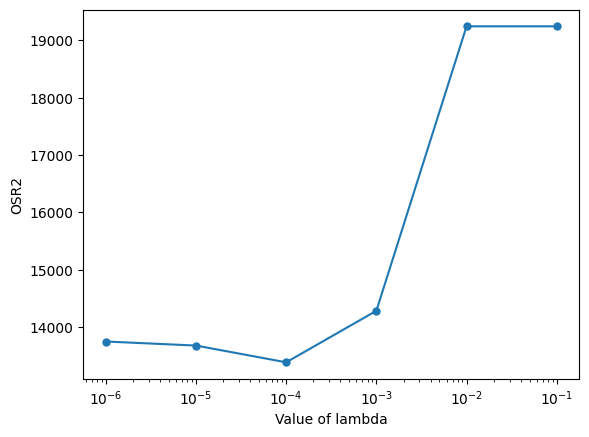

In [26]:
plt.plot(candidate_values, MAE_list,'o-', markersize = 5)
plt.xlabel('Value of lambda')
plt.ylabel('OSR2')
plt.xscale('log') 

## In-class activity 1: Create a similar plot for Ridge regression. The candidate value for labmda is `[ 1e-1, 1, 10, 1e2, 1e3, 1e4 ]`. Y-axis is the OSR2 and X-axis is the value of lambda.

In [27]:
OSR2_list = []
candidate = [ 1e-1, 1, 10, 1e2, 1e3, 1e4 ]

for alpha in candidate:
    ridge = Ridge(alpha=alpha, random_state=88)
    ridge.fit(X_train_lasso, y_train)
    y_pred_test = pd.Series(ridge.predict(X_test_lasso)).apply(np.exp).reset_index(drop=True)
    y_train_exp = y_train.copy().apply(np.exp).reset_index(drop=True)
    y_test_exp = y_test.copy().apply(np.exp).reset_index(drop=True)
    MAE_list.append(MAE(y_test_exp, y_pred_test))

Add Training set performance to the graph.

In [28]:
TrainingMAE_list = []
candidate_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

for alpha in candidate_values:
    lasso = Lasso(alpha=alpha, random_state=88)
    lasso.fit(X_train_lasso, y_train)
    y_pred_train = pd.Series(lasso.predict(X_train_lasso)).apply(np.exp).reset_index(drop=True)
    y_train_exp = y_train.copy().apply(np.exp).reset_index(drop=True)
    y_test_exp = y_test.copy().apply(np.exp).reset_index(drop=True)
    TrainingMAE_list.append(MAE(y_train_exp, y_pred_train))

ValueError: x and y must have same first dimension, but have shapes (6,) and (12,)

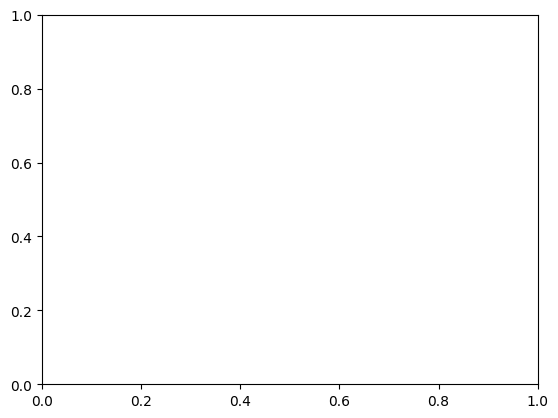

In [29]:
plt.plot(candidate_values, MAE_list,'o-', markersize = 5, label = 'Out-of-sample')
plt.plot(candidate_values, TrainingMAE_list,'o-', markersize = 5, label = 'In-sample')
plt.xlabel('Value of lambda')
plt.ylabel('')
plt.xscale('log') 
plt.legend();

### K-fold cross validation

In [ ]:
from sklearn.model_selection import GridSearchCV


alpha_grid = {'alpha': np.logspace(-8, -1, num=10, base=10)}

lasso_cv = GridSearchCV(lasso, param_grid = alpha_grid, scoring='neg_mean_squared_error', cv=10, verbose=1)
lasso_cv.fit(X_train_lasso, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

def one_standard_error_rule(model, results, param_grid, n_splits, neg_mean_squared_error=True):
    
    assert neg_mean_squared_error == True # function is defined specifically for neg_mean_squared_error
    
    range_x = param_grid # results['param_'+list(param_grid.keys())[0]].data
    std_vs_x  = pd.Series(results['std_test_score'], index = range_x)
    sem_vs_x  = std_vs_x/np.sqrt(n_splits)
    
    mean_vs_x = pd.Series(results['mean_test_score'], index = range_x)        
    mean_vs_x = mean_vs_x*(-1)
    
    x_min = mean_vs_x.idxmin()
    sem = sem_vs_x[x_min]
    
    if (model=='pcr'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.min()
    elif (model=='ridge') | (model=='lasso'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.max()
        
    #x_1se_idx = int(np.argwhere(range_x == x_1se)[0])
    
    return x_min, x_1se

In [ ]:
range_alpha = lasso_cv.cv_results_['param_alpha'].data
MSE_scores = lasso_cv.cv_results_['mean_test_score']*(-1)
x_min, x_1se = one_standard_error_rule(model='lasso',
                                       results=lasso_cv.cv_results_,
                                       param_grid=range_alpha,
                                       n_splits=10,
                                       neg_mean_squared_error=True)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('CV MSE', fontsize=16)
plt.scatter(range_alpha, MSE_scores, s=30)
plt.plot(range_alpha, MSE_scores)
plt.axvline(x=x_min, color='m')
plt.axvline(x=x_1se, color='c')
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

Magenta vertical line is the minimizer, the cyan vertical line is the "1 Standard Error" selection.

In [ ]:
acc = lasso_cv.cv_results_['mean_test_score'] # what sklearn calls mean_test_score is the holdout set, i.e. the validation set.
ccp = lasso_cv.cv_results_['param_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc})

In [ ]:
print('Alpha one standard error rule:', x_1se)

### Lasso Refit with One Standard Error Rule

In [ ]:
lasso_cv = GridSearchCV(lasso, {'alpha': [x_1se]}, scoring='neg_mean_squared_error', cv=10)
lasso_cv.fit(X_train_lasso, y_train)

print_metrics(lasso_cv, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = True)
#print_metrics(lasso_cv, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = False)

## Shuffle the dataset for k-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

alpha_grid = {'alpha': np.logspace(-8, -1, num=15, base=10)}
cv = KFold(n_splits = 10, random_state = 1, shuffle = True)
lasso_cv = GridSearchCV(lasso, param_grid = alpha_grid, scoring='neg_mean_squared_error', cv=cv, verbose=2)
lasso_cv.fit(X_train_lasso, y_train)

In [ ]:
range_alpha = lasso_cv.cv_results_['param_alpha'].data
MSE_scores = lasso_cv.cv_results_['mean_test_score']*(-1)
x_min, x_1se = one_standard_error_rule(model='lasso',
                                       results=lasso_cv.cv_results_,
                                       param_grid=range_alpha,
                                       n_splits=10,
                                       neg_mean_squared_error=True)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('CV MSE', fontsize=16)
plt.scatter(range_alpha, MSE_scores, s=30)
plt.plot(range_alpha, MSE_scores)
plt.axvline(x=x_min, color='m')
plt.axvline(x=x_1se, color='c')
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

## Custom loss function

In [ ]:
def large_prediction_error_count(y_test, y_pred, threshold = 2000):
    y_pred_test = pd.Series(y_pred).copy().apply(np.exp).reset_index(drop=True)
    y_test_exp = pd.Series(y_test).copy().apply(np.exp).reset_index(drop=True)
    count = [(y_pred_test - y_test_exp) > 2000]
    return np.sum(count)

In [ ]:
from sklearn.metrics import make_scorer  

alpha_grid = {'alpha': np.logspace(-8, -1, num=10, base=10)}
cv = KFold(n_splits = 10, random_state = 1, shuffle = True)
lasso_cv = GridSearchCV(lasso, param_grid = alpha_grid, scoring=make_scorer(large_prediction_error_count, greater_is_better=False), cv=cv, verbose=2)
lasso_cv.fit(X_train_lasso, y_train)

In [ ]:
range_alpha = lasso_cv.cv_results_['param_alpha'].data
new_scores = lasso_cv.cv_results_['mean_test_score']*(-1)

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('Customized loss', fontsize=16)
plt.scatter(range_alpha, new_scores, s=30)
plt.plot(range_alpha, new_scores)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

## Cross validation for Principal Components Regression

In [30]:
y_train = ames_train['LogSalePrice']
y_test = ames_test['LogSalePrice']

X_train_pcr = X_train_poly_wide
X_test_pcr = X_test_poly_wide

print(X_train_poly_wide.shape, X_train_pcr.shape)
print(X_test_poly_wide.shape, X_test_pcr.shape)

(1828, 397) (1828, 397)
(937, 397) (937, 397)


We also standardize the data before feeding it to the PCA step, as recommended by good practice.

In [31]:
from sklearn.pipeline import Pipeline
scaler = StandardScaler()
pca = PCA(random_state=88)
lr = LinearRegression()
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('lr', lr)])

Basic PCR

In [32]:
pipe.set_params(pca__n_components=5)
pipe.fit(X_train_pcr, y_train)
print_metrics(pipe, X_train_pcr, y_train, X_test_pcr, y_test, flag_log_sale_price = True)
print_metrics(pipe, X_train_pcr, y_train, X_test_pcr, y_test, flag_log_sale_price = False)


Metrics for Log(Sale Price):

Training R2 0.8669860382703731
Training MAE 0.09962977875968801
Training RMSE 0.14117035228048616
Out-of-sample R2 0.8396729663435233
Out-of-sample MAE 0.10399547659855168
Out-of-sample RMSE 0.15858777688396108

Metrics for Sale Price:

Training R2 0.897132348091005
Training MAE 17529.924419135274
Training RMSE 25055.73125787469
Out-of-sample R2 0.9018033283445104
Out-of-sample MAE 17377.607979840453
Out-of-sample RMSE 24560.576408359433


# In-class activity 2: For PCR, do a 5 fold cross validation value for `n_components` in terms of the `R-squared`. The potential  `n_components` is between 1 and 300. 
- What are the best R2 value and its corresponding n_components? 
- What is the value of `n_components` according to the one standard error rule?
- Refit the model using the `n_components` selected by the one standard error rule.

In [ ]:
param_grid = {'pca__n_components': np.linspace(1, 300, 35).astype('int')}

pcr_cv = GridSearchCV(pipe,
                      param_grid,
                      scoring='r2',
                      cv=5,
                     verbose = 2)
pcr_cv.fit(X_train_pcr, y_train)

In [ ]:
from scipy import stats

n_components = pcr_cv.cv_results_['param_pca__n_components'].data
R2_scores = pcr_cv.cv_results_['mean_test_score']
x_min, x_1se = one_standard_error_rule(model='pcr',
                                       results=pcr_cv.cv_results_,
                                       param_grid=n_components,
                                       n_splits=10,
                                       neg_mean_squared_error=True)

plt.figure(figsize=(8, 6))
plt.xlabel('n components', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(n_components, R2_scores, s=30)
plt.axvline(x=x_min, color='m')
plt.axvline(x=x_1se, color='c')
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [ ]:
best_r2_score = pcr_cv.best_score_
print("Best R2 Score from Cross-Validation:", best_r2_score)
best_n_components = pcr_cv.best_params_['pca__n_components']
print("Best n_components value:", best_n_components)

In [ ]:
print('pca n_components', x_1se)
index_x_1se = np.where(n_components == x_1se)[0][0]

# Get the corresponding R2 score
R2_score_x_1se = R2_scores[index_x_1se]
print("R2 Score corresponding to x_1se:", R2_score_x_1se)

In [ ]:
print_metrics(pcr_cv, X_train_pcr, y_train, X_test_pcr, y_test, flag_log_sale_price = True)
# print_metrics(pcr_cv, X_train_pcr, y_train, X_test_pcr, y_test, flag_log_sale_price = False)

#### Refit the model with the selected parameter

In [ ]:
pipe.set_params(pca__n_components=x_1se)
pipe.fit(X_train_lasso, y_train)
pipe.get_params()

In [ ]:
print_metrics(pipe, X_train_pcr, y_train, X_test_pcr, y_test, flag_log_sale_price = True)
print_metrics(pipe, X_train_pcr, y_train, X_test_pcr, y_test, flag_log_sale_price = False)

## Cross validation for Ridge Regression

We can choose `alpha_max` so as the value that makes all coefficientes zero, and then construct a log sequence of `alpha` values trending smaller, decreasing the degree of regularization. 

For the case of `Ridge` Regression, alpha value that would make all coefficients zero would be `Inf`, however we can be satisfied with sufficiently small numbers, and work from there.

In [ ]:
X_train_rr = X_train_poly_wide
X_test_rr = X_test_poly_wide

print(X_train_rr.shape, X_test_rr.shape)

### Determine 'alpha_max'

In [ ]:
from sklearn.linear_model import Ridge

alpha_max = 10**5
rr = Ridge(alpha=alpha_max, random_state=88)
rr.fit(X_train_rr, y_train)

### Ridge Hyper-parameter Tuning

In [ ]:
alpha_grid = {'alpha': np.logspace(-1, 5, num=50, base=10)}

rr = Ridge(random_state=88)
rr_cv = GridSearchCV(rr, alpha_grid, scoring='neg_mean_squared_error', cv=5)
rr_cv.fit(X_train_rr, y_train)

In [ ]:
range_alpha = rr_cv.cv_results_['param_alpha'].data
MSE_scores = rr_cv.cv_results_['mean_test_score']*(-1)
x_min, x_1se = one_standard_error_rule(model='ridge',
                                       results=rr_cv.cv_results_,
                                       param_grid=range_alpha,
                                       n_splits=10,
                                       neg_mean_squared_error=True)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('CV MSE', fontsize=16)
plt.scatter(range_alpha, MSE_scores, s=30)
plt.axvline(x=x_min, color='m')
plt.axvline(x=x_1se, color='c')
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [ ]:
print('Alpha one standard error rule:', x_1se)

### Ridge Refit with One Standard Error Rule

In [ ]:
lasso.set_params(alpha=x_1se)
lasso.fit(X_train_lasso, y_train)
lasso.get_params()

In [ ]:
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = True)
print_metrics(lasso, X_train_lasso, y_train, X_test_lasso, y_test, flag_log_sale_price = False)